# Total Competition
Example stacked bar plots with Formula 1 data from https://ergast.com/mrd/db

In [1]:
%autosave 0

Autosave disabled


In [2]:
from etl import DATADIR, ErgastF1
from viz import Plot

In [3]:
f1 = ErgastF1(DATADIR / 'ergast/f1.zip')
plot = Plot()

### What % of points went to each team on each year?

In [4]:
# Get team scores, race dates, and team names.
# Count points for each (year, team) since 1990.
data = (
    f1.team_results
    .loc[lambda df: df['points'] > 0]
    .join(f1.races['date'], on='id_race')
    .loc[lambda df: df['date'] > '1990']
    .join(f1.teams['team'], on='id_team')
    .groupby(['date', 'team'])
    ['points'].sum().unstack(fill_value=0)
    .resample('y').sum().rename_axis('year')
)

# Normalize each year's point total
data = data.div(data.sum(axis=1), axis=0)

# Convert units for easier reading
data = 100 * data.set_index(data.index.year)

# Is this table small enough yet?
print("{} rows x {} cols".format(*data.shape))
data.head()

30 rows x 39 cols


team,Alfa Romeo,Arrows,BAR,BMW Sauber,Benetton,Brabham,Brawn,Dallara,Ferrari,Footwork,...,Renault,Sauber,Spyker,Stewart,Super Aguri,Team Lotus,Toro Rosso,Toyota,Tyrrell,Williams
year,,,,,,,,,,,,,,,,,,,,,
1990,0.0,0.5,0.0,0.0,17.750000,0.500000,0.0,0.000000,27.500000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.750000,0.0,0.0,4.000000,14.250000
1991,0.0,0.0,0.0,0.0,9.553350,0.744417,0.0,1.240695,13.771712,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.744417,0.0,0.0,2.977667,31.017370
1992,0.0,0.0,0.0,0.0,21.875000,0.000000,0.0,0.480769,5.048077,1.442308,...,0.0,0.000000,0.0,0.0,0.0,3.125000,0.0,0.0,1.923077,39.423077
1993,0.0,0.0,0.0,0.0,17.307692,0.000000,0.0,0.000000,6.730769,0.961538,...,0.0,2.884615,0.0,0.0,0.0,2.884615,0.0,0.0,0.000000,40.384615
1994,0.0,0.0,0.0,0.0,24.759615,0.000000,0.0,0.000000,17.067308,2.163462,...,0.0,2.884615,0.0,0.0,0.0,0.000000,0.0,0.0,3.125000,28.365385


### focus on a few teams

In [5]:
# Too many columns makes the plot hard to read.
top12 = data.max().nlargest(12).index
data = data[top12]
print(*data.columns)

Ferrari Williams McLaren Mercedes Red Bull Benetton Renault Brawn BMW Sauber BAR Lotus F1 Jordan


### team colors

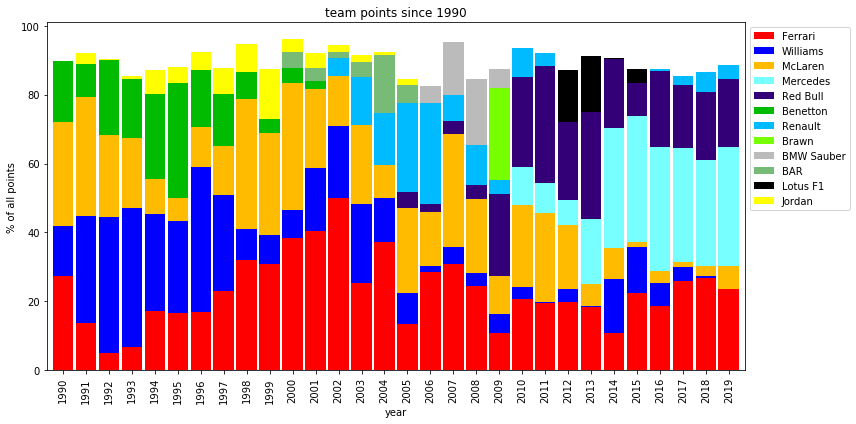

In [6]:
from collections import defaultdict

color = {
    'BAR': '#77bb77',
    'Benetton': '#00bb00',
    'BMW Sauber': '#bbbbbb',
    'Brawn': '#77ff00',
    'Ferrari': "#ff0000",
    'McLaren': "#ffbb00",
    'Mercedes': '#77ffff',
    'Red Bull': '#330077',
    'Renault': '#00bbff',
    'Williams': '#0000ff',
    'Jordan': '#ffff00'
}
color = defaultdict(lambda: "#000000", color)

kw = dict()
kw['color'] = data.columns.map(color)
kw['title'] = 'team points since 1990'
kw['ylabel'] = '% of all points'
axes = plot.bar(data, **kw)

### historical notes

#### 1986-1991: Honda Power
- Honda engines powered every 1986-1991 constructors' champion.
- McLaren-Honda won every 1988-1991 constructors' championship from 1988-1991.
- Senna won every 1988-1991 drivers' championship except 1989 (Prost).
- Prost left McLaren in 1990. Honda left F1 in 1993.

#### 1992-2004: Schuey vs. Newey
- In 1991, Michael Schumacher joined Benetton and Adrian Newey joined Williams.
- Safety rules changed mid-1994 after Senna and Ratzenberger suffered fatal accidents.
- The Michael won every drivers' championship from 1994-2004 except 1996 (Hill) and 1997 (Villeneuve).
- The Michael moved to Ferrari in 1996. Ross Brawn and several Benetton engineers joined him in 1997.
- Newey joined McLaren-Mercedes in 1997 after one year of "gardening leave."
- Häkkinen won 1998-1999 drivers' championships driving for McLaren-Mercedes.
- Ferrari won half of all points in 2002 and all 2000-2004 constructors' championships.

#### 2005-2009:  Challengers Appear
- Ferrari suffered under the "one tire rule" in 2005 except at Indianapolis.
- Alonso won the 2005 and 2006 drivers' championships with Renault, then moved to McLaren-Mercedes.
- McLaren's drivers, champ Alonso and rookie Hamilton, battled in 2007. Räikkonen won in a Ferrari.
- McLaren scored the most points in 2007 but were disqualified due to "Spygate."
- Ferrari won the 2008 constructors championship, but Hamilton won the drivers' in a McLaren-Mercedes.
- Brawn won the 2009 constructors' championship in their first year, then became Mercedes.
- Button won the 2009 drivers' championship, then moved to McLaren.

#### 2010-2013: They Gave Seb Wings
- Red Bull hired Newey in 2006 and Vettel (to their "b-team" Toro Rosso) in 2007.
- Vettel and Red Bull won all 2010-2013 drivers' and constructors' championships.

#### 2014-???: Hammer Time
- Mercedes won every constructor's championship of the "turbo hybrid era" since 2014.
- Hamilton won every drivers' championship since 2014 except 2016 (Rosberg).

## show all races for 1 year

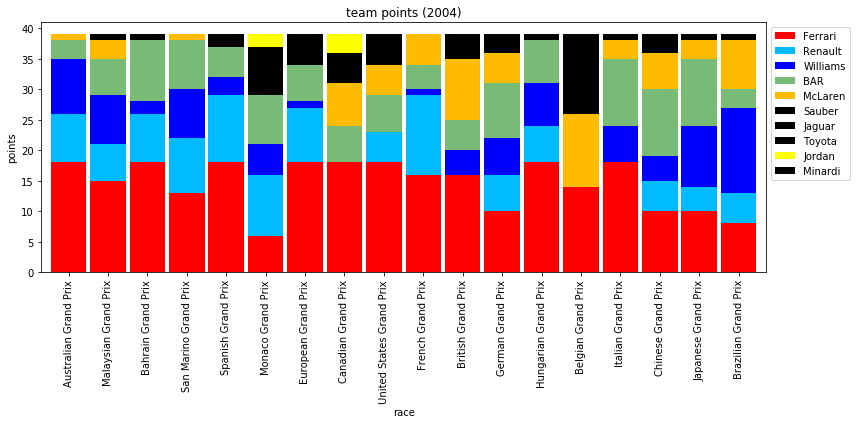

In [7]:
# Get team scores, race dates, race names, and team names.
# Count points for each (race, team) in 2004.
data = (
    f1.team_results
    .loc[lambda df: df['points'] > 0]
    .join(f1.races[['date', 'race']], on='id_race')
    .set_index('date').loc['2004'].sort_index()
    .join(f1.teams['team'], on='id_team')
    .groupby(['race', 'team'], sort=False)
    ['points'].sum().unstack(fill_value=0)
)
# Re-use the existing colors.
kw = dict()
kw['color'] = data.columns.map(color)
kw['title'] = 'team points (2004)'
kw['ylabel'] = 'points'
axes = plot.bar(data, **kw)